In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount(r"/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# cd '/content/drive/MyDrive/nasa_hackathon'


In [ ]:
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.signal import butter, filtfilt


In [ ]:
tf.__version__

'2.17.0'

In [ ]:
ls '/content/drive/MyDrive/nasa_hackathon '

ambient_temperature_system_failure.csv       xa.s12.00.mhz.1970-06-15HR00_evid00008.csv
Anomaly_Detection_in_Time_Series_Data.ipynb  xa.s12.00.mhz.1971-05-12HR00_evid00031.csv
apollo12_catalog_GradeA_final.csv            xa.s12.00.mhz.1971-05-12HR00_evid00032.csv
autoencoder_model.h5                         xa.s12.00.mhz.1971-05-13HR00_evid00033.csv
results/


In [ ]:
#easy signal only one hit.
# xa.s12.00.mhz.1970-06-15HR00_evid00008.csv

#double hit but first is quake
# xa.s12.00.mhz.1971-05-12HR00_evid00031.csv

#hard, double hit but second is quake
# xa.s12.00.mhz.1971-05-12HR00_evid00032.csv

# single highest hit in the start but data is noisy throughout
# xa.s12.00.mhz.1971-05-13HR00_evid00033.csv

# filtering functions

In [ ]:
# band pass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# moving average function
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

# load the earthquake trace

In [ ]:
# easy signal only one hit.
# xa.s12.00.mhz.1970-06-15HR00_evid00008.csv
# file_path = r'/content/drive/MyDrive/nasa_hackathon /xa.s12.00.mhz.1970-06-15HR00_evid00008.csv'
# data = pd.read_csv(file_path)

# double hit but first is quake
# when the timestamps are predicted there is a gap in between the quakes.
# the average is predicting the second one as quake.
# xa.s12.00.mhz.1971-05-12HR00_evid00031.csv
# file_path = r'/content/drive/MyDrive/nasa_hackathon /xa.s12.00.mhz.1971-05-12HR00_evid00031.csv'
# data = pd.read_csv(file_path)


# hard, double hit but second is quake
# xa.s12.00.mhz.1971-05-12HR00_evid00032.csv
file_path = r'/content/drive/MyDrive/nasa_hackathon /xa.s12.00.mhz.1971-05-12HR00_evid00032.csv'
data = pd.read_csv(file_path)


# single highest hit in the start but data is noisy throughout
# xa.s12.00.mhz.1971-05-13HR00_evid00033.csv
# fails because of lots of noise, need pre-processing.
# file_path = r'/content/drive/MyDrive/nasa_hackathon /xa.s12.00.mhz.1971-05-13HR00_evid00033.csv'
# data = pd.read_csv(file_path)


display(data)
# Exclude datetime column
# data_values = data.drop('timestamp',axis=1).values
data_values = data.drop(data.columns[[0, 1]], axis=1).values

# Convert data to float type
data_values = data_values.astype('float32')
print('original shape - >' , data_values.shape)

original_shape = data_values.shape

data_values = data_values.reshape(-1)
#moving average
data_values = moving_average(data_values, window_size=100)

# Filter your data
data_values = bandpass_filter(data_values, lowcut=0.5, highcut=1.0, fs=7)

# Normalizing data to range [-1, 1]
data_values = 2 * ((data_values - data_values.min()) / (data_values.max() - data_values.min())) - 1

print(data_values)
print(max(data_values))
print(min(data_values))

# reshape array
data_values = data_values.reshape(original_shape)
print('reshaped array - >' , data_values.shape)

# Create new dataframe with converted values
data_converted = pd.DataFrame(data_values, columns=['velocity'])

# Add back datetime column
# data_converted.insert(0, 'timestamp', data['timestamp'])

data_converted.insert(0, 'timestamp', data['time_rel(sec)'])


# Extract the filename from the file path
file_name = os.path.basename(file_path)

# get real impac time
# Path to the catalog file
catalog_file_path = r'/content/drive/MyDrive/nasa_hackathon /apollo12_catalog_GradeA_final.csv'

# Read the catalog CSV file
catalog = pd.read_csv(catalog_file_path)

# Extract the relative time for the corresponding filename

file_name, _ = os.path.splitext(file_name)

relative_time = catalog.loc[catalog['filename'] == file_name, 'time_rel(sec)']

print(relative_time)
# Check if the filename exists in the catalog and output the result
if not relative_time.empty:
    print(f'Relative time for {file_name} : {relative_time.values[0]} seconds')
else:
    print(f'Filename {file_name} not found in the catalog.')

data_converted = data_converted.dropna()
display(data_converted)

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1971-05-12T00:00:00.712000,0.000000,-6.579815e-16
1,1971-05-12T00:00:00.862943,0.150943,-8.333763e-16
2,1971-05-12T00:00:01.013887,0.301887,-9.389561e-16
3,1971-05-12T00:00:01.164830,0.452830,-9.307208e-16
4,1971-05-12T00:00:01.315774,0.603774,-8.207080e-16
...,...,...,...
572402,1971-05-13T00:00:01.013887,86400.301887,-4.352553e-16
572403,1971-05-13T00:00:01.164830,86400.452830,-6.182356e-16
572404,1971-05-13T00:00:01.315774,86400.603774,-7.570110e-16
572405,1971-05-13T00:00:01.466717,86400.754717,-9.248588e-16


original shape - > (572407, 1)
[-0.02873137 -0.02873136 -0.02873136 ... -0.02873136 -0.02873137
 -0.02873139]
1.0
-1.0
reshaped array - > (572407, 1)
23    35100.0
Name: time_rel(sec), dtype: float64
Relative time for xa.s12.00.mhz.1971-05-12HR00_evid00032 : 35100.0 seconds


,timestamp,velocity
0,0.000000,-0.028731
1,0.150943,-0.028731
2,0.301887,-0.028731
3,0.452830,-0.028731
4,0.603774,-0.028731
...,...,...
572402,86400.301887,-0.028731
572403,86400.452830,-0.028731
572404,86400.603774,-0.028731
572405,86400.754717,-0.028731


In [ ]:
# Exclude datetime column again
data_tensor = tf.convert_to_tensor(data_converted.drop('timestamp', axis=1).values, dtype=tf.float32)
print(data_tensor.shape)

(572407, 1)


# train the model

In [ ]:
# # Define the autoencoder model
# print(data_converted.shape)
# input_dim = data_converted.shape[1] - 1
# print(input_dim)
# encoding_dim = 5

# input_layer = Input(shape=(input_dim,))
# encoder = Dense(encoding_dim, activation='relu')(input_layer)
# decoder = Dense(input_dim, activation='relu')(encoder)
# autoencoder = Model(inputs=input_layer, outputs=decoder)



max lenght of input size is 572418

In [ ]:
# Compile and fit the model
# autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:

# autoencoder.fit(data_tensor, data_tensor, epochs=5, batch_size=32, shuffle=True)



# save the model

In [ ]:
# autoencoder.save(r'/content/drive/MyDrive/nasa_hackathon /autoencoder_model.h5')


# load the model

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Load the saved model from the specified path
autoencoder = load_model(r'/content/drive/MyDrive/nasa_hackathon /autoencoder_model.h5',
                          custom_objects={'mse': MeanSquaredError})
autoencoder.compile(optimizer='adam', loss='mse')

# take prediction

In [ ]:
# Calculate the reconstruction error for each data point
reconstructions = autoencoder.predict(data_tensor)
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),axis=1)
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = data_converted.index

threshold = anomaly_scores.quantile(0.99)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
precision, recall, f1_score, _ = precision_recall_fscore_support(binary_labels, anomalous, average='binary')


print(len(anomalous))
true_indexes = [i for i, x in enumerate(anomalous) if x]
print("Indexes of True values:", true_indexes)

print("lenght of True values:", len(true_indexes))


# Iterating over the DataFrame using the specified indices
anamolic_time_stamps = []
for index in true_indexes:
    row = data_converted.loc[index]
    anamolic_time_stamps.append(row['timestamp'])
    # print(f"Index: {index}, Row: {row.to_dict()}")

# the average of the timestamps will be the predicted answer.
# model predicts the index of those timestaps then we fetch the only predicted timestamps from the csv and take average.
avg = sum(anamolic_time_stamps) / len(anamolic_time_stamps)
print('predicted impact time -> ' , avg)

# print(relative_time)
print('real impact time -> ' , relative_time.values[0])


# Absolute Difference
difference = abs(avg - relative_time.values[0])
print(f"Absolute Difference: {difference}")

# Percentage Difference
percentage_difference = (difference / relative_time.values[0]) * 100
print(f"Percentage Difference: {percentage_difference:.2f}%")


17888/17888 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step
572407
Indexes of True values: [193184, 193188, 193192, 193273, 193300, 193315, 193316, 193331, 193332, 193338, 193339, 193342, 193343, 193344, 193345, 193358, 193359, 193387, 193388, 193391, 193392, 193393, 193396, 193397, 193398, 193405, 193406, 193407, 193410, 193411, 193412, 193413, 193415, 193416, 193417, 193420, 193421, 193422, 193423, 193438, 193439, 193440, 193443, 193444, 193451, 193453, 193454, 193455, 193456, 193458, 193459, 193460, 193461, 193463, 193464, 193465, 193466, 193470, 193471, 193478, 193479, 193480, 193481, 193484, 193485, 193486, 193487, 193489, 193490, 193491, 193492, 193495, 193496, 193505, 193506, 193507, 193509, 193510, 193511, 193514, 193515, 193516, 193524, 193528, 193529, 193541, 193544, 193545, 193546, 193549, 193550, 193551, 193553, 193554, 193555, 193556, 193558, 193559, 193560, 193561, 193565, 193566, 193582, 193586, 193587, 193590, 193591, 193594, 193595, 193596, 193599, 193608, 193609, 193610, 193613, 19

In [ ]:
import tensorflow as tf

# Convert the boolean list to a TensorFlow tensor
anomalous_tensor = tf.constant(anomalous)

# 1. Get the values from `data_tensor` that correspond to `True` in `anomalous`
true_values = tf.boolean_mask(data_tensor, anomalous_tensor)
print("Values corresponding to True indices in data_tensor:", true_values.numpy())

# 2. Get the indexes of the `True` values in the `anomalous` list
true_indexes = tf.where(anomalous_tensor).numpy().flatten()
print("Indexes of True values:", true_indexes)

# Optional: Print the values along with their corresponding indexes
for index in true_indexes:
    print(f"Index: {index}, Value: {data_tensor[index].numpy()}")


Streaming output truncated to the last 5000 lines.
Index: 195485, Value: [0.27970466]
Index: 195490, Value: [-0.32573283]
Index: 195491, Value: [-0.31655052]
Index: 195505, Value: [-0.33723953]
Index: 195506, Value: [-0.26547444]
Index: 195509, Value: [0.41829583]
Index: 195510, Value: [0.36968976]
Index: 195513, Value: [-0.3692664]
Index: 195514, Value: [-0.37763938]
Index: 195526, Value: [-0.27938613]
Index: 195540, Value: [-0.3131532]
Index: 195541, Value: [-0.36082414]
Index: 195545, Value: [0.30530375]
Index: 195550, Value: [-0.27097923]
Index: 195555, Value: [0.25882417]
Index: 195556, Value: [0.29738104]
Index: 195559, Value: [-0.32098997]
Index: 195560, Value: [-0.46501032]
Index: 195561, Value: [-0.38690084]
Index: 195564, Value: [0.40140098]
Index: 195565, Value: [0.3335807]
Index: 195567, Value: [-0.25499496]
Index: 195568, Value: [-0.39873445]
Index: 195569, Value: [-0.2840807]
Index: 195571, Value: [0.28359118]
Index: 195572, Value: [0.34702983]
Index: 195575, Value: [-0.4

In [ ]:
# test = data_converted['value'].values
test = data_converted['velocity'].values

predictions = anomaly_scores.values

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


# plot prediction

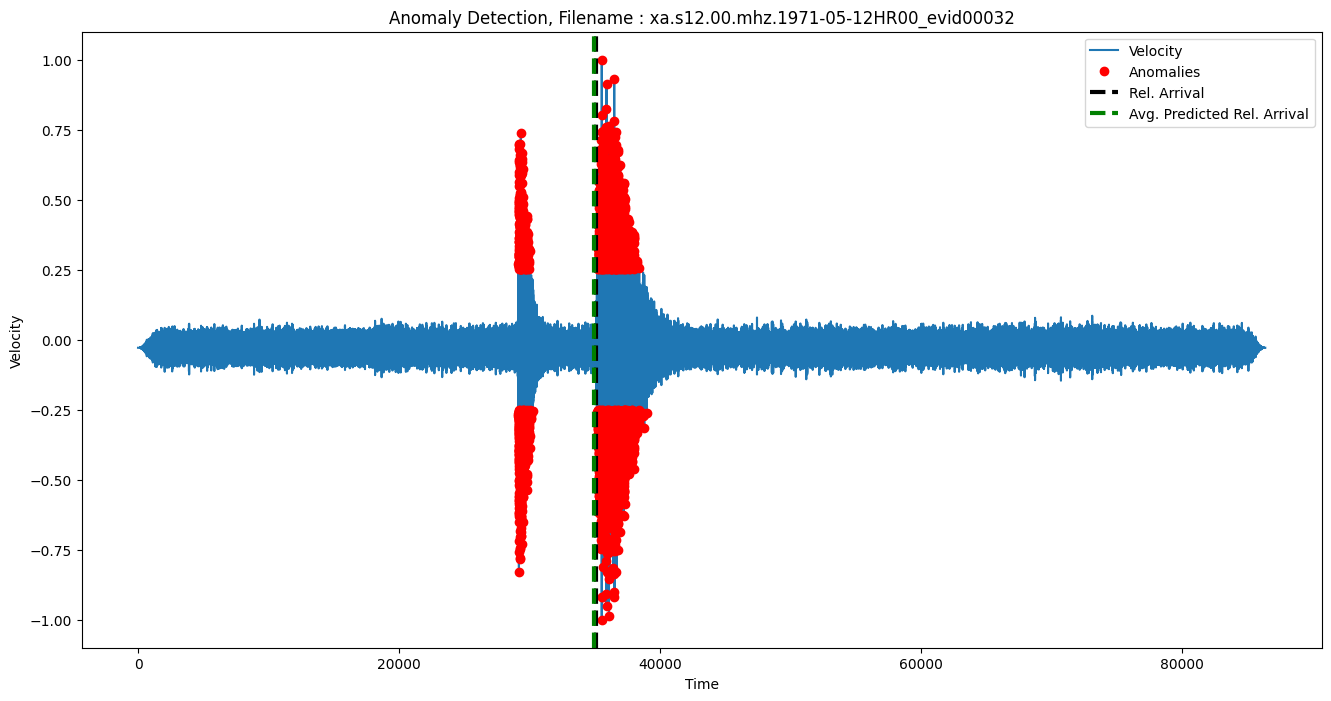

In [ ]:
import matplotlib.pyplot as plt

# Plot the data with anomalies marked in red
plt.figure(figsize=(16, 8))
plt.plot(data_converted['timestamp'], data_converted['velocity'], label='Velocity')

# Mark anomalies in red on the same plot
plt.plot(data_converted['timestamp'][anomalous], data_converted['velocity'][anomalous], 'ro', label='Anomalies')

# Draw a green vertical line at the exact index of `relative_time.values[0]`
plt.axvline(x=relative_time.values[0], color='black', linestyle='--', linewidth=3 , label='Rel. Arrival')

plt.axvline(x=avg, color='green', linestyle='--', linewidth=3, label='Avg. Predicted Rel. Arrival')

# Add title and labels
plt.title(f'Anomaly Detection, Filename : {file_name}')
plt.xlabel('Time')
plt.ylabel('Velocity')

# Show the legend
plt.legend()

# Show the plot
plt.show()


# clustering (not working)

In [ ]:
# import numpy as np
# from sklearn.cluster import KMeans

# # Assuming your anomalous data is a Pandas Series
# # Convert it to a NumPy array if it's a Series
# # anomalous_np = anomalous.values  # If it's a Pandas Series

# # Optional: Print the values along with their corresponding indexes
# # for index in true_indexes:
# #     print(f"Index: {index}, Value: {data_tensor[index].numpy()}")

# print(len(true_indexes))

# anomalous_np = true_indexes  # If it's a Pandas Series

# print(anomalous_np)
# # Reshape the anomalous array to fit the KMeans input
# anomalous_reshaped = anomalous_np.reshape(-1, 1)

# print(anomalous_reshaped)
# # Define the number of clusters (e.g., 2 in this case)
# n_clusters = 2

# # Apply KMeans clustering
# kmeans = KMeans(n_clusters=n_clusters)
# kmeans.fit(anomalous_reshaped)

# # Get the cluster labels for each anomalous index
# labels = kmeans.labels_

# # Create groups based on the cluster labels
# groups = [anomalous_np[labels == i] for i in range(n_clusters)]

# # Print the groups
# for i, group in enumerate(groups):
#     print(f"Group {i+1}: {group}")
#     print(f"lenght of Group {i+1}: {len(group)}")
#     print(f"avg impact time of group {i+1} is  {sum(group)/len(group)}")



In [ ]:
# (240888.42217856363 + 95231.46765734267) /2

In [ ]:
# # Print the groups
# for i, group in enumerate(groups):
#     for g in group:
#       print(g)
#     print('end')

